[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239412-lesson-5-router)

# Router

## Review

We built a graph that uses `messages` as state and a chat model with bound tools.

We saw that the graph can:

* Return a tool call
* Return a natural language response

## Goals

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is an simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly.

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output!

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model model output, and route to our tool calling node or simply end if no tool call is performed.



In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GEMINI_API_KEY")

GEMINI_API_KEY: ··········


**Note:** Obtain the necessary json key from the Google Cloud Console by following the instructions outlined in step 21_langchain_ecosystem/langchain/-01_gemini_standalone/Gemini_API_python.ipynb file. Once acquired, load the json key in Google Colab to proceed with the project.

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/<your-json-key-here>"

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=os.environ["GEMINI_API_KEY"])
llm_with_tools = llm.bind_tools([multiply])

**Note:** Warning indicates that the title key is being generated internally, likely within LangGraph or the Gemini integration when the tool is being bound, rather than being passed explicitly. So ignore the warning.


 We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it.

 We use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge.

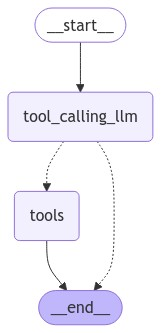

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph.state import CompiledStateGraph

# Node
def tool_calling_llm(state: MessagesState) -> MessagesState:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply])) #It will take function name and arguments then it call the function and give back the output in return then will decide to give it to agent or return to the user
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello world.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello world.
================================== Ai Message ==================================

Hello! How can I help you today?


In [7]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Multiply 2 and 3.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (ba06839c-f158-4c07-b68b-57f5d4ae5abd)
 Call ID: ba06839c-f158-4c07-b68b-57f5d4ae5abd
  Args:
    b: 3.0
    a: 2.0
================================= Tool Message =================================
Name: multiply

6


Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`.

## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Load the `router` in Studio, which uses `module-1/studio/router.py` set in `module-1/studio/langgraph.json`.